# Developing a Machine Learning Model to Localize Sensor Nodes in a Wireless Sensor Network

In [9]:
# We are training our models on Training_SYL_All_30.csv
# and testing it on Testing_SYL_All.csv
import pandas as pd

# train_df = pd.read_csv('./SYL/Training_SYL_All_30.csv')
# test_df  = pd.read_csv('./SYL/Testing_SYL_All.csv')

train_df = pd.read_csv('./CETC331/Training_CETC331.csv')
test_df  = pd.read_csv('./CETC331/Testing_CETC331.csv')

In [10]:
# Replace +100 with -200 for RSSI values indicating undetected MACs. 
train_df.replace(100, -200, inplace=True)
test_df.replace(100, -200, inplace=True)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
# pca = PCA(n_components=0.99)

X_train = train_df.drop(['ECoord', 'NCoord', 'FloorID', 'BuildingID', 'SceneID', 'UserID', 'PhoneID', 'SampleTimes'], axis=1)
X_test = test_df.drop(['ECoord', 'NCoord', 'FloorID', 'BuildingID', 'SceneID', 'UserID', 'PhoneID', 'SampleTimes'], axis=1)

# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the target variables for training
y_train_e = train_df['ECoord']
y_train_n = train_df['NCoord']

# Define the target variables for testing
y_test_e = test_df['ECoord']
y_test_n = test_df['NCoord']

X_train.shape

(955, 52)

In [11]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
def grid_search(X_train, y_train):
    pipe_svr = make_pipeline(StandardScaler(), SVR())

    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
    poly_param_range = [2, 3, 4, 5, 6]

    param_grid = [
        # {'svr__C': param_range, 'svr__kernel': ['linear']},
        {'svr__C': param_range, 'svr__gamma': param_range, 'svr__kernel': ['rbf']},
        # {'svr__C': param_range, 'svr__gamma': param_range, 'svr__kernel': ['sigmoid']},
        # {'svr__C': param_range, 'svr__gamma': param_range, 'svr__kernel': ['poly'], 'svr__degree': poly_param_range}
    ]

    cv = 5 #KFold(n_splits=10, shuffle=True, random_state=42)

    gs = GridSearchCV(estimator=pipe_svr, 
                        param_grid=param_grid, 
                        scoring='neg_mean_squared_error', 
                        refit=True,
                        cv=cv,
                        n_jobs=-1)

    gs = gs.fit(X_train, y_train)
    return gs


In [12]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# For 'ECoord'
gs_e = grid_search(X_train, y_train_e)  
y_pred_e = gs_e.best_estimator_.predict(X_test)

mse_e = mean_squared_error(y_test_e, y_pred_e)
rmse_e = sqrt(mse_e)
R2_score_e = r2_score(y_test_e, y_pred_e)

print(f'ECoord - RMSE = {rmse_e}, R^2 = {R2_score_e}')
print(f'ECoord - Best Parameters: {gs_e.best_params_}')

# SYL ECoord - RMSE = 8.637005604291845, R^2 = 0.8180068969463883
# SYL ECoord - Best Parameters: {'svr__C': 10.0, 'svr__gamma': 0.0001, 'svr__kernel': 'rbf'}

# HCXY ECoord - RMSE = 8.52772400637756, R^2 = 0.942511576759094
# HCXY ECoord - Best Parameters: {'svr__C': 1.0, 'svr__gamma': 0.0001, 'svr__kernel': 'rbf'}

# CETC331: ECoord - RMSE = 3.420589033859438, R^2 = 0.03241945547961134
# CETC331: ECoord - Best Parameters: {'svr__C': 1.0, 'svr__gamma': 1.0, 'svr__kernel': 'rbf'}


ECoord - RMSE = 3.493355505338812, R^2 = -0.009185258111642725
ECoord - Best Parameters: {'svr__C': 0.0001, 'svr__gamma': 10.0, 'svr__kernel': 'rbf'}


In [13]:
# For 'NCoord'
gs_n = grid_search(X_train, y_train_n) 
y_pred_n = gs_n.best_estimator_.predict(X_test)

mse_n = mean_squared_error(y_test_n, y_pred_n)
rmse_n = sqrt(mse_n)
R2_score_n = r2_score(y_test_n, y_pred_n)

print(f'NCoord - RMSE = {rmse_n}, R^2 = {R2_score_n}')
print(f'NCoord - Best Parameters: {gs_n.best_params_}')

# SYL NCoord - RMSE = 3.428539330800415, R^2 = 0.7767418892714244
# SYL NCoord - Best Parameters: {'svr__C': 1.0, 'svr__gamma': 0.0001, 'svr__kernel': 'rbf'}

# HCXY NCoord - RMSE = 2.7869217545249914, R^2 = 0.9712302025492057
# HCXY NCoord - Best Parameters: {'svr__C': 10.0, 'svr__gamma': 0.0001, 'svr__kernel': 'rbf'}

# CETC331: NCoord - RMSE = 5.53535772656438, R^2 = 0.9008011375147562
# CETC331: NCoord - Best Parameters: {'svr__C': 10.0, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}

NCoord - RMSE = 10.928272846499006, R^2 = 0.6133496873331654
NCoord - Best Parameters: {'svr__C': 10.0, 'svr__gamma': 0.0001, 'svr__kernel': 'rbf'}


In [14]:
import numpy as np
# Calculate the Euclidean distances between actual and predicted points
distances = np.sqrt((y_test_e - y_pred_e) ** 2 + (y_test_n - y_pred_n) ** 2)

# Compute the mean distance error across all predictions
mean_distance_error = np.mean(distances)

print(f"Mean Distance Error: {mean_distance_error}")

# SYL Mean Distance Error: 6.595476878871486

# HCXY Mean Distance Error: 6.701827375081162

# CETC331: Mean Distance Error: 5.298857340503742


Mean Distance Error: 8.999289565616571


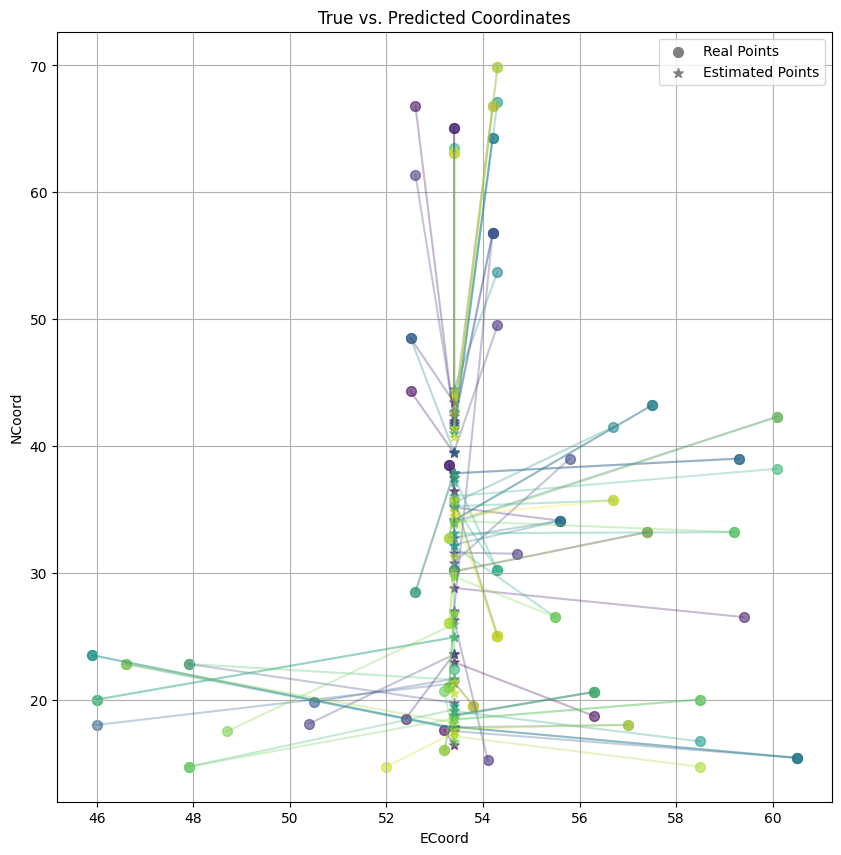

In [15]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(11)
# Assuming X_test, y_test_e, y_test_n, gs_e, and gs_n are defined elsewhere in your code

random_indices = np.random.choice(X_test.shape[0], size=100, replace=False)
X_test_random = X_test[random_indices]

y_pred_random_e = gs_e.best_estimator_.predict(X_test_random)
y_pred_random_n = gs_n.best_estimator_.predict(X_test_random)

# Extracting the true values for the randomly selected indices
y_test_random_e = y_test_e.iloc[random_indices]
y_test_random_n = y_test_n.iloc[random_indices]

plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('viridis', 100)

# Dummy plots for legend
plt.scatter([], [], marker='o', label='Real Points', s=50, color='gray')
plt.scatter([], [], marker='*', label='Estimated Points', s=50, color='gray')

for i, (true_e, true_n, pred_e, pred_n) in enumerate(zip(y_test_random_e, y_test_random_n, y_pred_random_e, y_pred_random_n)):
    color = cmap(i)
    # Plotting the real points with circles
    plt.scatter(true_e, true_n, marker='o', s=50, alpha=0.6, color=color)
    # Plotting the estimated points with x's
    plt.scatter(pred_e, pred_n, marker='*', s=50, alpha=0.6, color=color)
    # Optionally, draw lines between real and estimated points
    plt.plot([true_e, pred_e], [true_n, pred_n], '-', alpha=0.3, color=color)

plt.legend(loc='upper right')
plt.title('True vs. Predicted Coordinates')
plt.xlabel('ECoord')
plt.ylabel('NCoord')
plt.grid(True)
plt.show()
